In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 6
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 10月 06日 星期六 00:11:28 CST


In [55]:
! ls -l '../data/validate/2018-10-09_19-40-26_noup/' | tail

-rw-rw-r-- 1 meta meta  2278 10月  9 21:34 2018-10-09_21-34-04_210_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  8103 10月  9 21:34 2018-10-09_21-34-26_313_mcts-mcts_newnet-oldnet_w.cbf
-rw-rw-r-- 1 meta meta  4953 10月  9 21:34 2018-10-09_21-34-27_598_mcts-mcts_newnet-oldnet_w.cbf
-rw-rw-r-- 1 meta meta  3128 10月  9 21:34 2018-10-09_21-34-58_508_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  4353 10月  9 21:35 2018-10-09_21-35-26_651_mcts-mcts_newnet-oldnet_w.cbf
-rw-rw-r-- 1 meta meta  3928 10月  9 21:35 2018-10-09_21-35-41_706_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  6853 10月  9 21:36 2018-10-09_21-36-57_95_mcts-mcts_oldnet-newnet_peace.cbf
-rw-rw-r-- 1 meta meta  5528 10月  9 21:38 2018-10-09_21-38-14_366_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  8303 10月  9 21:42 2018-10-09_21-42-09_62_mcts-mcts_oldnet-newnet_peace.cbf
-rw-rw-r-- 1 meta meta 11603 10月 10 05:53 2018-10-10_05-53-45_167_mcts-mcts_oldnet-newnet_peace.cbf


In [73]:

fullpath = '../data/validate/2018-10-09_19-40-26_noup/2018-10-09_21-34-58_508_mcts-mcts_oldnet-newnet_b.cbf'
moves = cbf.cbf2move(fullpath)
fname = fullpath.split('/')[-1]
print(fname)
state = gameplay.GameState()

2018-10-09_21-34-58_508_mcts-mcts_oldnet-newnet_b.cbf


In [74]:
from PIL import Image
import imageio
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
for i in moves[:]: 
    statestr = GameBoard.sim_do_action(i,statestr)
    imgs_for_gif.append(board_visualizer.get_board_img(statestr))
    state.do_move(i)
imgs_for_gif = imgs_for_gif[:]
imageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

In [75]:
i,len(moves)

('f0e0', 89)

In [76]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

In [77]:
display_gif('../data/gif/{}.gif'.format(fname[:-4]))

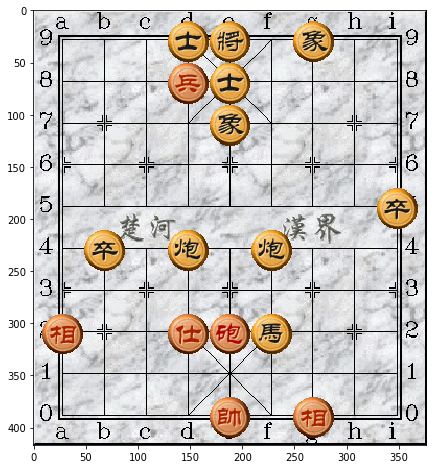

In [78]:
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))

# ANALYSIS

In [190]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-09-18_12-17-55'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-09-18_12-17-55


In [191]:
network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=1)

In [192]:
network_player.make_move(state=state,actual_move=False)

('d0e1', 0.27222076058387756)

In [193]:
network_player.mcts_policy._root._Q

-0.27222076058387756

In [194]:
childs = network_player.mcts_policy._root._children
probs = []
for move in childs:
    val = childs[move]
    print(move,val._n_visits,val._P,val._Q)
    probs.append(val._P)

f0e0 0 0.00044749718 0
f1d2 0 0.00046235902 0
f1h0 0 0.00051732425 0
f1h2 0 0.0005318151 0
d0e1 0 0.00049346173 0
f2e1 0 0.00044057117 0
c4a2 0 0.00052182574 0
g0i2 0 0.0004998675 0
c4e2 0 0.0005166623 0


In [195]:
datajson = get_km_json(network_player.mcts_policy,state.statestr,depth=40)

In [196]:
!mkdir '../data/mstc_vis'

mkdir: 无法创建目录"../data/mstc_vis": 文件已存在


In [197]:
with open('../data/mstc_vis/sample.km','w') as whdl:
    json.dump(datajson,whdl)